In [1]:
import sys
sys.path.insert(0, 'visualization.py')
sys.path.insert(0, 'utils.py')

In [2]:
# /!\ Before running the lab make sure every additional libraries is installed 

# Import local libraries
from visualization import *
from utils import *


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Task n°1


This exercise is about showing measurements made by the Intelligent Road-Side Unit (IRSU) positioned at the center of the intersection:
- 1 point clouds collected by a 32-channel LiDAR

The functions you need to modify are located in:
-  box_to_corner -> visualization.py

-  get_boxes_in_actor_frame -> utils.py

In [3]:
n_frame = 30
actor = 'ego_vehicle'

irsu_points = get_point_cloud(n_frame, actor)
irsu_boxes = get_boxes_in_actor_frame(n_frame, actor)
print(irsu_boxes.shape)
box_colors = CLASS_COLORS[irsu_boxes[:, -1].astype(np.int32)]


show_objects(irsu_points[:,:3], irsu_boxes[:,:7], box_colors)

(12, 8)


# Task n°2

This exercise demonstrates how the field of view and perception range of a vehicle can be enhanced by receiving data from other vehicles and the IRSU.

The functions you need to modify are:
-  box_to_corner (already done in task 1) -> visualization.py
-  get_available_point_clouds, get_available_boxes_in_ego_frame, get_boxes_in_actor_frame(already done in task 1) -> utils.py

In [4]:
n_frame = 0
actors = ["ego_vehicle" ,"other_vehicle",   "ego_vehicle_behind","other_vehicle_behind" ,"infrastructure",]#

merged_points = get_available_point_clouds(n_frame, actors)
irsu_boxes = get_available_boxes_in_ego_frame(n_frame, actors)
box_colors = CLASS_COLORS[irsu_boxes[:, -1].astype(np.int32)]

show_objects(merged_points, irsu_boxes[:,:7], box_colors)

# Task n°3

Build a BEV occupancy grid of the environment

A main challenge in perception on point clouds is their unordered nature which hinders the application of the Convolution operation, thus preventing the use of many wonders in the world of image-based perception. An effective way to get around this challenge is to convert point clouds to BEV images. In other word, to look at a point cloud from the top-view which is what you are going to do in this exercise.

The functions you need to modify are :
-  box_to_pixels, points_to_pixels-> visualization.py
-  filter_points -> utils.py

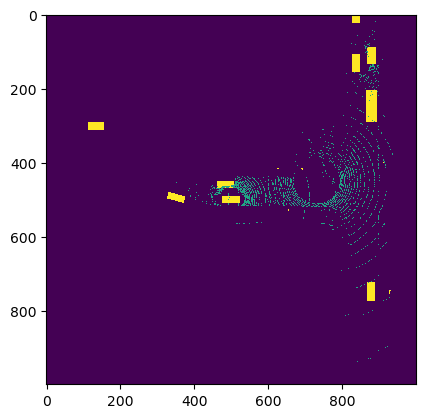

In [3]:

n_frame = 0
actors = ["ego_vehicle" ,"other_vehicle",   "ego_vehicle_behind","other_vehicle_behind","infrastructure",]
merged_points = get_available_point_clouds(n_frame, actors)
irsu_boxes = get_available_boxes_in_ego_frame(n_frame, actors)
box_colors = CLASS_COLORS[irsu_boxes[:, -1].astype(np.int32)]

# ------------------ Get Waypoints that belongs to the ground floor ------------------
points_range = np.array([-50, -50, -25, 50, 50, 0.01])  # xmin, ymin, zmin, xmax, ymax, zmax (meters) around ego_vehicle

filtered_points = filter_points(merged_points, points_range)
show_objects(filtered_points, irsu_boxes[:,:7], box_colors)

# ------------------  Build BEV image  ------------------  
bev_resolution = 0.1 # meters / pixel
bev_imsize = np.ceil((points_range[3: 5] - points_range[:2]) / bev_resolution).astype(int)  # (width, height)
bev_occupancy = np.zeros((bev_imsize[1], bev_imsize[0]))

# ------------------  Project bbox of actors on the image  ------------------  
box_mask = box_to_pixels(irsu_boxes[:,:7], bev_imsize, bev_resolution)
bev_occupancy[box_mask > 0] = 255

# ------------------  Project navigable space on the image ------------------  
navigable_space = points_to_pixels(filtered_points, bev_imsize, bev_resolution)

for pixel in navigable_space:
    bev_occupancy[pixel[1], pixel[0]] = 150


plt.imshow(bev_occupancy)


# Task n°4: 
Segment points according to object's class

In [ ]:

# Define the voxel grid resolution
voxel_resolution = 0.1  # meters

# Calculate the voxel grid dimensions
x_min, y_min, z_min = merged_points.min(axis=0)
x_max, y_max, z_max = merged_points.max(axis=0)
voxel_grid_shape = np.ceil((x_max - x_min, y_max - y_min, z_max - z_min) / voxel_resolution).astype(int)

# Initialize the voxel grid with zeros
voxel_grid = np.zeros((*voxel_grid_shape, 3))

# Segment points by coloring it, each color represents a different class and all the points inside a bounding box or in the same cluster belong to the same class
segmented_points = []

for class_id, class_name in enumerate(CLASS_NAMES):
    class_color = CLASS_COLORS[class_id]
    
    # Filter boxes of the current class
    class_boxes = irsu_boxes[irsu_boxes[:, -1] == class_id]
    
    for box in class_boxes:
        # Preprocess the box to get the range
        box_center = box[:3]
        box_size = box[3:6]
        
        # Define the range for filtering points without a margin
        x_min, y_min, z_min = box_center - box_size / 2
        x_max, y_max, z_max = box_center + box_size / 2
        points_range = np.array([x_min, y_min, z_min, x_max, y_max, z_max])
        
        # Filter points within the bounding box
        points_in_box = filter_points(merged_points, points_range)
        
        # Assign color to the points
        colored_points = np.hstack((points_in_box, np.tile(class_color, (points_in_box.shape[0], 1))))
        segmented_points.append(colored_points)

segmented_points = np.vstack(segmented_points)

# Show the segmented points on the 3D plot
show_objects(segmented_points[:,:3], irsu_boxes[:,:7], box_colors)


TypeError: unsupported operand type(s) for /: 'tuple' and 'float'